In [3]:
using CSV
using DataFrames
using Plots
using Interpolations
using IJulia
using ColorSchemes
using LaTeXStrings
using Optim
using Statistics
gr()

using FFTW
using FINUFFT

In [95]:
function sma(x::Vector, before::Int64, after::Int64)
    replace!(x, NaN=>0)
    x_a = copy(x)
    for i in 1:after
        x_a .+= vcat(x[i+1:end],x[end-(i-1):end])
    end
    for i in 1:before
        x_a .+= vcat(x[1:i],x[1:end-(i)])
    end
    return x_a./(1+after+before)
end

sma (generic function with 1 method)

## Read the dump file

In [2]:
function read_dump_file(f_path::String,N::Integer,TS::Integer; Δt = 100, τ = 0.0083, logspace = true, need_sort=false)
    # N = #particles, TS = #Timesteps, Δt = Timesteps between each meassurement
    T = TS÷Δt
    #Build timeseries
    if logspace
        time = Array(0.:9.)
        i = 1
        run = true
        while run
            for j in 2:19
                if i*j*5 > TS
                    run = false
                    break
                else
                    append!(time,i*j*5)
                end
            end
            i*=10
        end
        time.*=τ
    else
        time = Array(0:Δt:TS).*τ
    end
    
    #Initialize matrix for data
    out = zeros(N,4,length(time))
    for t in 1:length(time)
        df = CSV.File(f_path; skipto=10+(N+9)*(t-1), limit=N,delim = " ", header = ["id", "_type", "x", "y", "z"],ignorerepeated=true)
        if need_sort
            df = DataFrame(df)
            sort!(df,[:id])
        end
        out[:,1,t] = df.x
        out[:,2,t] = df.y
        out[:,3,t] = df.z
        out[:,4,t] = df._type
    end
    
    return out, time
end

function read_dump_file_v2(f_path::String; wrapped::Bool = false)
    # Define number of particles in the system
    N = 0
    open(f_path) do f
        while ! eof(f) 
            if occursin("NUMBER OF ATOMS", readline(f))
                N = parse(Int64,readline(f))
                break
            end
        end
    end
    #println("Number of particles = $(N)")
    
    dfs = Dict()
    
    # Iterate through all the timesteps
    ts = 0
    open(f_path) do f
        while length(dfs) < 100 && ! eof(f) #while ! eof(f)
            # Define current timestep
            if occursin("TIMESTEP", readline(f))
                ts = parse(Int64,readline(f))
            end
            if occursin("ITEM: ATOMS", readline(f))
                Id = zeros(Int64,N)
                Type = zeros(Int64,N)
                x = zeros(Float64,N)
                y = zeros(Float64,N)
                z = zeros(Float64,N)
                if wrapped
                    xw = zeros(Float64,N)
                    yw = zeros(Float64,N)
                    zw = zeros(Float64,N)
                end
                
                for i in 1:N
                    d = split(strip(readline(f))," ")
                    Id[i] = parse(Int64,d[1])
                    Type[i] = parse(Int64,d[2])
                    x[i] = parse(Float64,d[3])
                    y[i] = parse(Float64,d[4])
                    z[i] = parse(Float64,d[5])
                    if wrapped
                        xw[i] = parse(Float64,d[6])
                        yw[i] = parse(Float64,d[7])
                        zw[i] = parse(Float64,d[8])
                    end 
                end
                
                if wrapped
                    df = DataFrame(Id=Id, Type=Type, x=x, y=y, z=z, xw=xw, yw=yw, zw=zw)
                else
                    df = DataFrame(Id=Id, Type=Type, x=x, y=y, z=z)
                end
                
                dfs[ts] = sort(df,[:Id])
                
                if ts == 0
                    dfs[ts][!,"Δr2"] = zeros(Float64,N)
                else
                    dfs[ts][!,"Δr2"] = (dfs[0].x .- dfs[ts].x).^2 .+ (dfs[0].y .- dfs[ts].y).^2 .+ (dfs[0].z .- dfs[ts].z).^2
                end
                
            end
        end
    end
    return dfs, sort(collect(keys(dfs)))
end


read_dump_file_v2 (generic function with 1 method)

## The incoherent intermediate scattering function

$$F_S(\vec{k},t) = \frac{1}{N}\Big\langle \sum^N_{j=1}exp[i\vec{k}.(\vec{r}_j(t)-\vec{r}_j(0))\Big\rangle$$

In [4]:
function ISF(r::Array{Float64, 3},k::Float64)
    @assert size(r,2) == 4
    N, T = size(r,1), size(r,3)
    r₀ = r[:,:,1]
    Fₖ = zeros(T)
    for t in 1:T
        Fₖ[t] = (1/(3*N))*sum(cos.(k*(r[:,1,t].-r₀[:,1])).+cos.(k*(r[:,2,t].-r₀[:,2])).+cos.(k*(r[:,3,t].-r₀[:,3])))
        + (1/(3*N))*sum(sin.(k*(r[:,1,t].-r₀[:,1])).+sin.(k*(r[:,2,t].-r₀[:,2])).+sin.(k*(r[:,3,t].-r₀[:,3])))
    end
    return Fₖ
end

function ISF(r::Dict{Any, Any},ts::Vector{Any},k::Float64)
    N = nrow(r[0])
    r₀ = r[0]
    Fₖ = zeros(length(ts))
    for (i,t) in enumerate(ts)
        Fₖ[i] = (1/(3*N))*sum(cos.(k*(r[t].x .- r₀.x)).+cos.(k*(r[t].y .- r₀.y)).+cos.(k*(r[t].z .- r₀.z)))
        + (1/(3*N))*sum(sin.(k*(r[t].x .- r₀.x)).+sin.(k*(r[t].y .- r₀.y)).+sin.(k*(r[t].z .- r₀.z)))
    end
    return Fₖ
end

ISF (generic function with 2 methods)

In [ ]:
f_path = "../Sim_results/bcc16000_v2/pos_014K.dump"
f_path2="../Sim_results/results_with_wrapped/pos_014K_1.dump"
#r,t= read_dump_file(f_path,16000,2000000,need_sort=true)
r2,ts2= read_dump_file_v2(f_path2);

In [ ]:
r2[5]

### Read data and calculate scattering function

In [115]:
κ = 6.1
temps = ["200","100","070","050","030","020","017","015","014","013","012","010","005","0005"] #"0001", "008","001"
#temps = ["200", "014"]
t =  Dict{String,Vector{Float64}}()
Fₖ =  Dict{String,Vector{Float64}}()
t0 = time()
for (i,temp) in enumerate(temps)
    if temp in  ["005", "010", "012","013","014","015", "017","030","050", "100"]
        
        M = temp in ["014", "010", "012", "005", "013", "015", "017"] ? 10 : 5
        
        Fₖ[temp] = zeros(100)
        for m in 1:M
            f_path="../Sim_results/results_with_wrapped/pos_$(temp)K_$(m).dump"
            #f_path = "../Sim_results/bcc16000_v2/pos_$(temp)K.dump"
            r,ts = read_dump_file_v2(f_path)
            for timestep in ts
                r[timestep] = filter(:Type => t -> t == 2, r[timestep]) #Filter out only B-type
            end
            Fₖ[temp] .+= ISF(r,ts,κ);
            t[temp]= ts.*0.0083
            t[temp][1] = 1e-3
        end

        Fₖ[temp] ./= M
        
    else
        f_path = "../Sim_results/bcc16000_v2/pos_$(temp)K.dump"
        #r,t[temp] = read_dump_file(f_path,16000,2000000,need_sort=true)
        r,ts = read_dump_file_v2(f_path)
        for timestep in ts
            r[timestep] = filter(:Type => t -> t == 2, r[timestep]) #Filter out only B-type
        end
        Fₖ[temp] = ISF(r,ts,κ);
        t[temp]= ts.*0.0083
        t[temp][1] = 1e-3
    end

    prog=trunc(Int, 10*i/length(temps))
    IJulia.clear_output(true)
    print("Progress: ",repeat("▮",prog),repeat("▯",10-prog)," $(10*prog)%")
end
println(" Runtime: " *string(round(time()-t0))* " seconds")

Progress: ▮▮▮▮▮▮▮▮▮▮ 100% Runtime: 707.0 seconds


### Plot results

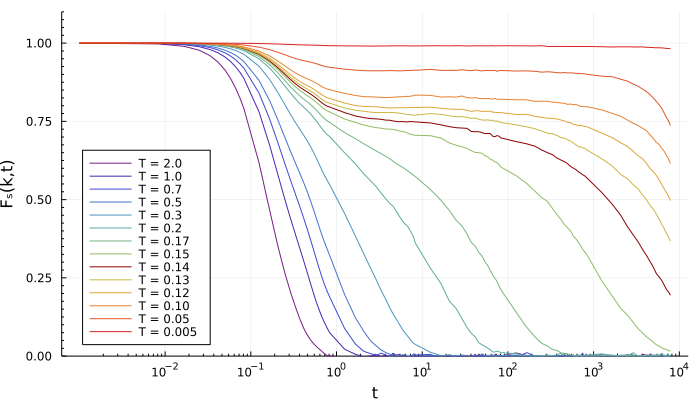

In [116]:
p = plot(xaxis=(:log10, [1e-3, :auto]),minorticks=10, dpi = 1500, xlabel="t", xticks = (10*ones(7)).^Array(-2:4), 
            ylabel="Fₛ(k,t)",legend=:bottomleft,size = (700, 400), ylim=(0,1.1))
#colors = range(colorant"red", stop=colorant"blue", length=length(temps))
#colors = range(HSL(colorant"red"), stop=HSL(colorant"blue"), length=20)
colors = get(ColorSchemes.rainbow,range(0,1,length(temps)))

for (i,temp) in enumerate(temps)
    if length(temp)>3
        p = plot!(t[temp],Fₖ[temp],label = "T = "*string(parse(Int,temp)/(100*(10*(length(temp)-3)))),color = colors[i])
    elseif temp == "014"
        p = plot!(t[temp],Fₖ[temp],label = "T = "*string(parse(Int,temp)/(100)),color = "dark red")
    elseif temp == "010"
        p = plot!(t[temp],Fₖ[temp],label = "T = 0.10",color = colors[i])
    else 
        p = plot!(t[temp],Fₖ[temp],label = "T = "*string(parse(Int,temp)/(100)),color = colors[i])
    end 
end
display(p)

In [118]:
#savefig(p, "scattering_function6.pdf")

## 4 point susceptibility $\chi_4$(t)

In [ ]:
N = length(t["100"])
xj = Array(1:N).*(2*π) ./N

shifted_k = fftshift(fftfreq(N)*N)

temp = "100"
p2 = plot(shifted_k,imag.(ifftshift(ifft(Fₖ[temp]))),xaxis=(:log10, [1e-3, :auto]),minorticks=5, dpi = 1500, xlabel = "log(ω)"
    ,legend=:bottomleft,size = (800, 500),label = "T = $(temp)")
ylims!((0,0.6))

temp = "014"
p2 = plot!(shifted_k,imag.(ifftshift(ifft(Fₖ[temp]))) ./0.14,xaxis=(:log10, [1e-3, :auto]),minorticks=5, dpi = 1500, xlabel = "log(ω)", 
            legend=:bottomleft,size = (800, 500),label = "T = $(temp)")

temp = "005"
p2 = plot!(shifted_k,imag.(ifftshift(ifft(Fₖ[temp]))) ./0.05,xaxis=(:log10, [1e-3, :auto]),minorticks=5, dpi = 1500, xlabel = "log(ω)", 
            legend=:bottomleft,size = (800, 500),label = "T = $(temp)")



# temp = "014"
# p2 = plot(t[temp],abs.(ifft(Fₖ[temp])),xaxis=(:log10, [1e-3, :auto]),minorticks=5, dpi = 1500, xlabel = "log(ω)", 
#             ylabel="Fₛ(q,t)",legend=:bottomleft,size = (800, 500),label = "fft")
# p2 = plot!(t[temp],abs.(ifftshift(ifft(Fₖ[temp]))),label ="fft shifted")
# ylims!((0,0.2))

In [ ]:
shifted_k

In [ ]:
x = Array(range(0.1,4*π,100))
y = sin.(log10.(x)) .+ sin.(3 .* log10.(x))
display(plot(x,y))

ms = 3000      # output size (number of Fourier modes)
tol = 1e-8        # requested relative tolerance

# Output as return value (1e6 pts to 2e6 modes takes about 0.1 sec)...
F = fftshift(fft(y))
freqs = fftshift(fftfreq(length(x), 100))
display(plot(freqs,abs.(F)))

### Direct calculation

In [112]:
κ = 6.1

w(x,a₀) = x .<= a₀

Q(r2,a₀) = sum(w(sqrt.(r2), a₀))

function χ₄(temp::String, useQ::Bool = false)
    a₀ = 0.2
    M = temp in ["014", "010", "012", "005", "013", "015", "017"] ? 10 : 5
    
    f_path="../Sim_results/results_with_wrapped/pos_$(temp)K_1.dump"
    df,ts= read_dump_file_v2(f_path)
    N = length(df[ts[1]].x)
    results = zeros(length(ts),M)
    
    if useQ
        results[:,1] = [Q(df[τ].Δr2, a₀) for τ in ts]
    else
        for timestep in ts
            df[timestep] = filter(:Type => t -> t == 2, df[timestep]) #Filter out only B-type
        end
        results[:,1] = ISF(df,ts,κ)
        N = length(df[ts[1]].x)
    end
    
    for m in 2:M
        f_path="../Sim_results/results_with_wrapped/pos_$(temp)K_$(m).dump"
        df,ts= read_dump_file_v2(f_path)
        if useQ
            results[:,m] = [Q(df[τ].Δr2, a₀) for τ in ts]
        else
            for timestep in ts
                df[timestep] = filter(:Type => t -> t == 2, df[timestep]) #Filter out only B-type
            end
            results[:,m] = ISF(df,ts,κ)
        end
    end
    return mean(results, dims=2), var(results, dims=2) .* N, ts 
end

χ₄ (generic function with 2 methods)

In [129]:
lw = 1.6 # Linewidth

colors = get(ColorSchemes.rainbow,range(0,1,7))

p7 = plot(xaxis=(:log10, [1e-1, :auto]),minorticks=10, dpi = 1500, xlabel="t", xticks = (10*ones(7)).^Array(-2:4), 
            ylabel="χ₄(t)",legend=:topleft,size = (700, 500), ylims=(0,25))
p8 = plot(xaxis=(:log10, [1e-1, :auto]),minorticks=10, dpi = 1500, xlabel="t", xticks = (10*ones(7)).^Array(-2:4), 
            ylabel="F(t)",legend=:bottomleft,size = (700, 400))
for (j,temp) in enumerate(["005", "010","013","014","015", "017", "100"]) #, "012","030","050"
    q,x,ts = χ₄(temp)
    p7 = plot!(p7, ts .* 0.0083 ,sma(x[:],1,1),label = "T = "*string(parse(Int,temp)/(100)), linewidth = lw, color = colors[j])
    p8 = plot!(p8, ts .* 0.0083 ,q,label = "T = "*string(parse(Int,temp)/(100)), linewidth = lw)
end

In [133]:
p7
savefig(p7, "susceptibility4.pdf")

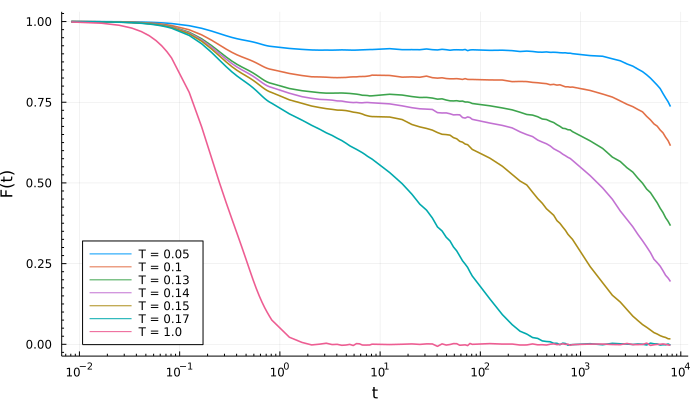

In [121]:
p8

## $\alpha_2$-parameter

In [122]:
function α₂(r::Vector{Float64})
    return (2/5)*(mean(r.^4) / (mean(r.^2)^2)) -1
end

function calc_α₂(temp::String)
    M = temp in ["014", "010", "012", "005"] ? 10 : 5
    
    f_path="../Sim_results/results_with_wrapped/pos_$(temp)K_1.dump"
    df,ts= read_dump_file_v2(f_path)
    results = zeros(length(ts),M)
    
    for timestep in ts
        df[timestep] = filter(:Type => t -> t == 2, df[timestep]) #Filter out only B-type
    end
    results[:,1] = [α₂(df[τ].Δr2) for τ in ts]
    
    for m in 2:M
        f_path="../Sim_results/results_with_wrapped/pos_$(temp)K_$(m).dump"
        df,ts= read_dump_file_v2(f_path)
        for timestep in ts
            df[timestep] = filter(:Type => t -> t == 2, df[timestep]) #Filter out only B-type
        end
        results[:,m] = [α₂(df[τ].Δr2) for τ in ts]
        
    end
    return mean(results, dims=2), var(results, dims=2), ts 
end

calc_α₂ (generic function with 1 method)

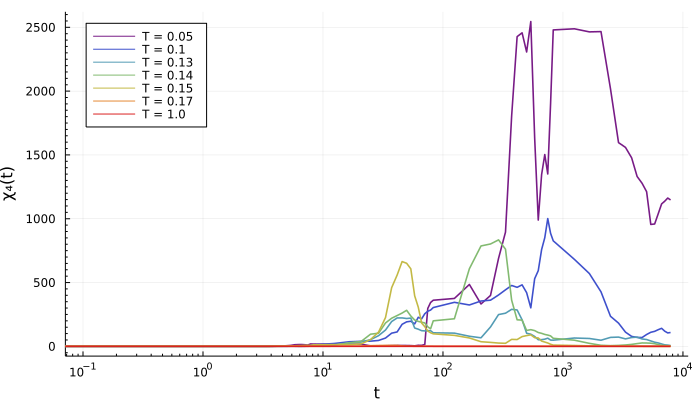

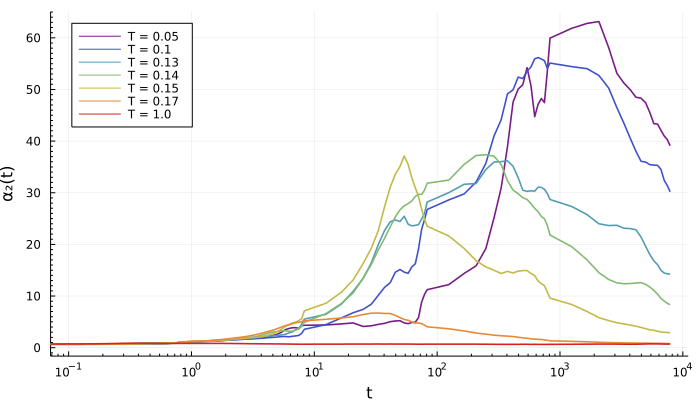

In [131]:
lw = 1.6 # Linewidth

colors = get(ColorSchemes.rainbow,range(0,1,7))

p9 = plot(xaxis=(:log10, [1e-1, :auto]),minorticks=10, dpi = 1500, xlabel="t", xticks = (10*ones(7)).^Array(-2:4), 
            ylabel="χ₄(t)",legend=:topleft,size = (700, 400))
p10 = plot(xaxis=(:log10, [1e-1, :auto]),minorticks=10, dpi = 1500, xlabel="t", xticks = (10*ones(7)).^Array(-2:4), 
            ylabel="α₂(t)",legend=:topleft,size = (700, 400))
for (j,temp) in enumerate(["005", "010","013","014","015", "017", "100"]) #, "012","030","050"
    q,x,ts = calc_α₂(temp)
    p9 = plot!(p9, ts .* 0.0083 ,sma(x[:],2,2),label = "T = "*string(parse(Int,temp)/(100)), linewidth = lw, color = colors[j])
    p10 = plot!(p10, ts .* 0.0083 ,sma(q[:],2,2),label = "T = "*string(parse(Int,temp)/(100)), linewidth = lw, color = colors[j])
end

display(p9)
display(p10)

In [132]:
savefig(p10, "alpha2_4.pdf")

In [90]:

q,x,ts = calc_α₂("014")

([NaN; 0.6440435605766572; … ; 8.284321241616741; 8.22259185512662;;], [NaN; 0.004874040480186445; … ; 4.5812490697522685; 5.43206977086088;;], Any[0, 1, 2, 3, 4, 5, 6, 7, 8, 9  …  500000, 550000, 600000, 650000, 700000, 750000, 800000, 850000, 900000, 950000])

In [96]:
sma(q[:],1,1)

100-element Vector{Float64}:
  0.21468118685888574
  0.42944677606432896
  0.6428716476516072
  0.6416149579570031
  0.6398132242669554
  0.6392132689959956
  0.6388352617727379
  0.638930389380706
  0.639137217967741
  0.6394356470958317
  0.6427292180826906
  0.6499287822872648
  0.6615168058476802
  ⋮
 12.139511877485168
 12.538448811170994
 12.762929048835241
 12.67089230159924
 12.473338570882504
 11.86437157412494
 11.231701844051697
 10.233492135105399
  9.520321207521391
  8.807927804467166
  8.396829109835425
  8.243168317289994

## Fitting of KWW function
Assume $F_s(t)$ to be described through the Kohlrausch-Williams-Watts function:
$$F_s(t) \sim A \exp(-(t/\tau)^{\beta})$$


In [76]:
κ = 6.1
temps = ["014", "100"]
t =  Dict{String,Vector{Float64}}()
Fₖ =  Dict{String,Vector{Float64}}()
t0 = time()
for (i,temp) in enumerate(temps)
    
    M = temp in ["014"] ? 10 : 5
    Fₖ[temp] = zeros(100)
    
    for m in 1:M
        f_path="../Sim_results/results_with_wrapped/pos_$(temp)K_$(m).dump"
        #f_path = "../Sim_results/bcc16000_v2/pos_$(temp)K.dump"
        r,ts = read_dump_file_v2(f_path)
        for timestep in ts
            r[timestep] = filter(:Type => t -> t == 2, r[timestep]) #Filter out only B-type
        end
        Fₖ[temp] .+= ISF(r,ts,κ);
        t[temp]= ts.*0.0083
        t[temp][1] = 1e-3
    end
    
    Fₖ[temp] ./= M

    prog=trunc(Int, 10*i/length(temps))
    IJulia.clear_output(true)
    print("Progress: ",repeat("▮",prog),repeat("▯",10-prog)," $(10*prog)%")
end
println(" Runtime: " *string(round(time()-t0))* " seconds")

Progress: ▮▮▮▮▮▮▮▮▮▮ 100% Runtime: 118.0 seconds


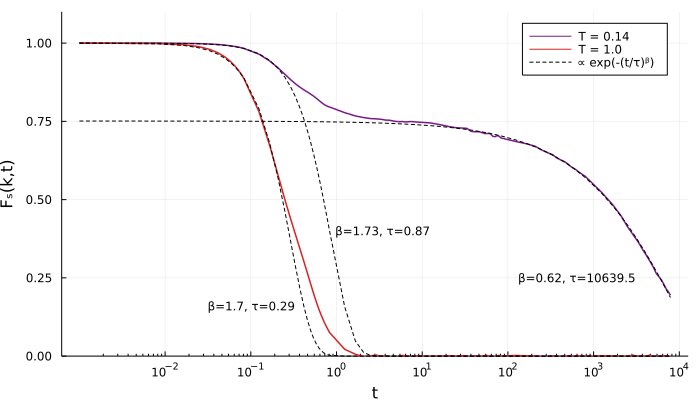

 * Status: success

 * Candidate solution
    Final objective value:     3.175900e-04

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    47
    f(x) calls:    90

 * Status: success

 * Candidate solution
    Final objective value:     5.614687e-04

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    54
    f(x) calls:    105



In [77]:
p = plot(xaxis=(:log10, [1e-3, :auto]),xminorticks=10, dpi = 1500, xlabel="t",xticks = (10*ones(7)).^Array(-2:4),
            ylabel="Fₛ(k,t)",legend=:topright,size = (700, 400), ylim=(0,1.1))

colors = get(ColorSchemes.rainbow,range(0,1,length(temps)))
for (i,temp) in enumerate(temps)
    p = plot!(t[temp],Fₖ[temp],label = "T = "*string(parse(Int,temp)/(100)),color = colors[i], linewidth = 1.5)
end


################
T = "100"

t_min = 3#5
t_max = 14#20

# Objective function:
f(X;t_min = t_min, t_max = t_max) = sum((Fₖ[T][t_min:t_max] .- exp.(-(t[T][t_min:t_max]./abs(X[1])).^X[2])).^2)
# Optimize:
X0 = [1.0,1.0]
res = optimize(f,X0)
X_sol = Optim.minimizer(res)

τ, β = (abs(X_sol[1]), X_sol[2])

p = plot!(t[T],exp.(-(t[T]./τ).^β),
    label = "∝ exp(-(t/τ)ᵝ)", style=:dash, color = "black")
#p = vline!([t[T][t_min],t[T][t_max]], label = "")
annotate!(p, 0.32, 0.16, text("β=$(round(X_sol[2],digits = 2)), τ=$(round(abs(X_sol[1]),digits = 2))", :black, :right, 8))

# println("τ =", X_sol[1])
# println("β =", X_sol[2])
println(res)

################
T = "014"

t_min = 3
t_max = 14

# Objective function:
f(X;t_min = t_min, t_max = t_max) = sum((Fₖ[T][t_min:t_max] .- exp.(-(t[T][t_min:t_max]./X[1]).^X[2])).^2)
# Optimize:
X0 = [1.0,1.0]
res = optimize(f,X0)
X_sol = Optim.minimizer(res)

τ, β = (X_sol[1], X_sol[2])

p = plot!(t[T],exp.(-(t[T]./τ).^β),label = "", style=:dash, color = "black")
#p = vline!([t[T][t_min],t[T][t_max]], label = "", alpha = 0.4)
annotate!(p, 12, 0.40, text("β=$(round(X_sol[2],digits = 2)), τ=$(round(X_sol[1],digits = 2))", :black, :right, 8))

## α-relaxation ##
t_min = 47
t_max = 88

# Objective function:
f(X;t_min = t_min, t_max = t_max) = sum((Fₖ[T][t_min:t_max] .- (exp.(-(t[T][t_min:t_max]./abs(X[1])).^X[2]) .- X[3])).^2)
# Optimize:
X0 = [7000,0.5, 0.27]
res = optimize(f,X0)
X_sol = Optim.minimizer(res)

τ, β, ξ = (abs(X_sol[1]), X_sol[2], X_sol[3])

p = plot!(t[T],exp.(-(t[T]./τ).^β) .- ξ,label = "", style=:dash, color = "black")
#p = vline!([t[T][t_min],t[T][t_max]], label = "", alpha = 0.4)
annotate!(p, 3000, 0.25, text("β=$(round(X_sol[2],digits = 2)), τ=$(round(abs(X_sol[1]),digits = 2))", :black, :right, 8))


display(p)
savefig(p, "scattering_function_approx3.pdf")

# println("τ =", X_sol[1])
# println("β =", X_sol[2])
println(res)